#  Unsupervised learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["animation.html"] = "jshtml"

In [3]:
import sys
sys.path.append('../..')

In the gaussian mixture models - EM notebook we have used the mixture models for _density estimation_ e.g. modeling the  distribution of features in each class. Another common application is _clustering_. Technically this looks the same as fitting the GMM to a single class. 

Let's assume we have $K$ components

$\newcommand{\b}[1]{\mathbf{#1}}$
$$p(\b x|\b \theta) = \sum_{k=1}^K\pi_k p_\mathcal{N}(\b x|\b\mu_k,\b\Sigma_k)$$

Generalizing the two component example from GMM-EM lecture we can introduce the latent variables $\b z\in \{0,1\}^K$ i.e. each $\b z$ is a vector of length $K$ with all entries set to zero except entry $k$ set to one which indicates that this point belongs to $k$-th  component. This is called $1-K$ encoding. 

$$z_i = \{0,\ldots,1,\ldots,0\}$$

The joint distribution in $\b x$ and $\b z$ is given by

$$p(\b x, \b z|\b \theta) = \sum_{k=1}^K\pi_k z_k p_\mathcal{N}(\b x|\b\mu_k,\b\Sigma_k)$$

Please note that only one term in the sum on the right hand side is non-zero. 

From Bayes theorem the probability that point $\b x$ belongs to cluster $k$

$$
\gamma_k(\b x)\equiv p(z_k=1|\b x, \theta)=
\frac{ \pi_k p_\mathcal{N}(\b x|\b\mu_k,\b\Sigma_k)}
{\sum_{k=1}^K\pi_k  p_\mathcal{N}(\b x|\b\mu_k,\b\Sigma_k)}
$$

$\gamma_k(\b x)$ is called _responsibility_ of $\b x$ for cluster $k$ and as a probability can take value from zero to one. This is called _soft clustering_. Of course we can use this number to define a _hard clustering_ by _e.g._ assigning points to the cluster with  highest responsibility. 

###  Sex from heigh and weight

Let's apply this to  the sex from height&weight example.

In [4]:
from mchlearn.datasets import load_height_weight

In [5]:
hw_data = load_height_weight('../../Data/HeightWeight/weight-height.csv')

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
hw_train, hw_test = train_test_split(hw_data, test_size=0.2)

In [8]:
from sklearn.mixture import GaussianMixture

In [9]:
hw_gm = GaussianMixture(n_components=2, tol=1e-5, n_init=3)

In [10]:
hw_gm.fit(hw_train[['Height','Weight']])

GaussianMixture(n_components=2, n_init=3, tol=1e-05)

Let's look at the found clusters 

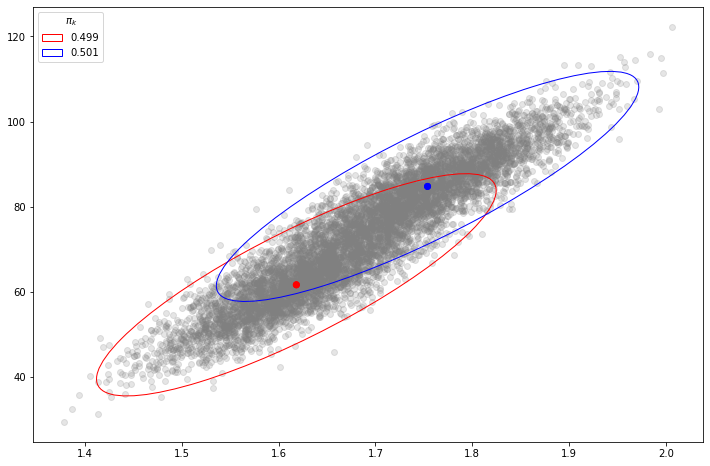

In [11]:
from mchlearn.plotting import confidence_ellipse
plt.scatter(hw_train['Height'], hw_train['Weight'], alpha=0.2, color='grey');
colors=['red', 'blue']
for i in range(2):
    confidence_ellipse(hw_gm.means_[i], hw_gm.covariances_[i], ax = plt.gca(), edgecolor=colors[i], label =f"{hw_gm.weights_[i]:5.3f}");
    plt.scatter(*np.split(hw_gm.means_,2,1), facecolors=colors)
plt.legend(title='$\pi_k$');    

Looks very reasonable :) 

Please recall that the because of the unidentifiability  of the parameters the particular assignment of labels to clusters is meaningless. That's a knowledge that we have to put in "by hand". Below I choose the women cluster as the one with smaller average height. 

In [12]:
female = np.argmin(hw_gm.means_[:,0])

Let's compare the results to the separate fit to each cluster _i.e._ quadratic discriminant analysis

In [13]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(hw_train[['Height','Weight']], hw_train.Gender=='Female')

QuadraticDiscriminantAnalysis(store_covariance=True)

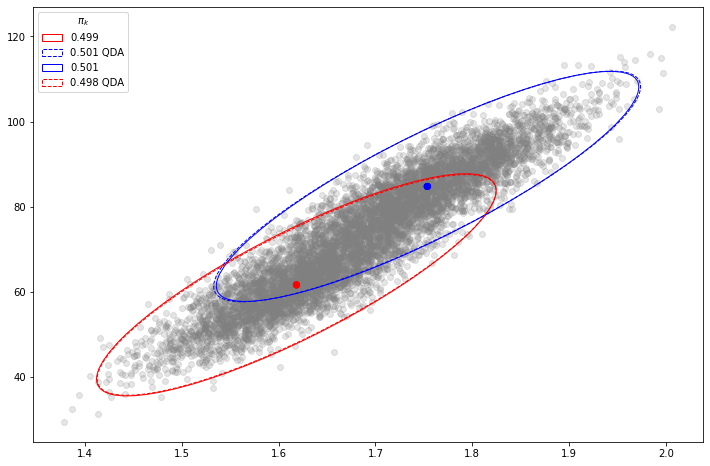

In [14]:
from mchlearn.plotting import confidence_ellipse
plt.scatter(hw_train['Height'], hw_train['Weight'], alpha=0.2, color='grey');
qda_colors = [colors[1-female],colors[female]]
for i in range(2):
    confidence_ellipse(hw_gm.means_[i], hw_gm.covariances_[i], ax = plt.gca(), edgecolor=colors[i], label =f"{hw_gm.weights_[i]:5.3f}");
    plt.scatter(*np.split(hw_gm.means_,2,1), facecolors=colors)
    confidence_ellipse(qda.means_[i], qda.covariance_[i], ax = plt.gca(), edgecolor=qda_colors[i], label =f"{qda.priors_[i]:5.3f} QDA", linestyle='--');
    plt.scatter(*np.split(qda.means_,2,1), edgecolors=qda_colors, facecolors='none')
plt.legend(title='$\pi_k$');    

As we can see the results are very similar. We can use those (EM fitted) cluster for classification

In [15]:
from sklearn.metrics import confusion_matrix
test_proba = hw_gm.predict_proba(hw_test[['Height','Weight']])
confusion_matrix(hw_test.Gender=='Female', test_proba[:,female]>0.5, normalize='true')

array([[0.93117409, 0.06882591],
       [0.07411067, 0.92588933]])

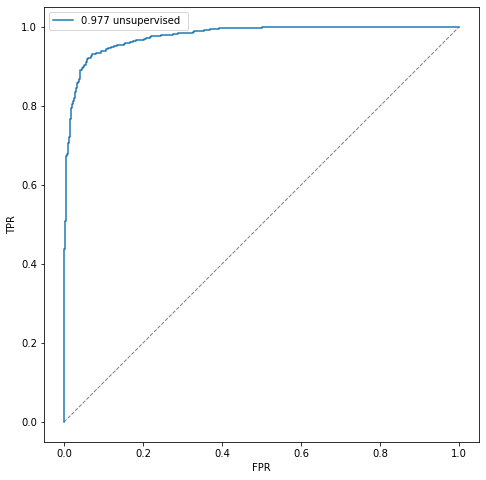

In [16]:
from mchlearn.plotting import roc_plot, add_roc_curve
fig, ax = roc_plot()
add_roc_curve(hw_test.Gender=='Female', test_proba[:,female], name='unsupervised', ax =ax);
ax.legend();

As you can see we are getting results similar to supervised learning. However in this analysis we have overlooked some very important issues.

## Choosing  the number of components

While technically the procedure of fitting is similar to supervised learning with gaussian mixture discriminative analysis (GMDA) the crucial difference lies in the interpretation. 

In GMDA the clusters are only a mean to better approximation of the class probability densities and their interpretation is irrelevant for the functioning of the classifier. We can choose the number of clusters that gives best classification results, because we have clear metrics to measure the performance.

In clustering we usually want to discover the structure of data and assign some interpretation to discovered clusters. But the  number of clusters is an input parameter. In the height-weight examples we knew that  this was two so the results were good. And we have used the real labels to check that. 

But this is not a case in general. We could experiment with different number of clusters but we need the criteria for evaluating the quality of clustering in absence of real labels.

### Negative Log Likelihood

As what we are doing is to find the distribution that  fits the data bests, we could use the log likelihood (LL) as the measure of the performance. And that's what EM lagorithm does: it tries to maximize the likelihood. It is customary to use instead the _negative log likelihood_  (NNL) which contrary to the name is positive :) The smaller NNL the better. For calculating the log likehood we can use the `score` method that returns the average LL:

In [17]:
-hw_gm.score(hw_train[['Height', 'Weight']])

2.1852381411110393

However we have already used the LL to fit on the same data. I hope that by now you know that you cannot do that and that this estimate is biased. We can try it on the test set:

In [18]:
-hw_gm.score(hw_test[['Height', 'Weight']])

2.1738250696794506

and indeed we get a bigger, hence worse value. 

Let's compare this to fit with three clusters

In [19]:
hw_gm3 = GaussianMixture(n_components=3, tol=1e-5, n_init=3)

In [20]:
hw_gm3.fit(hw_train[['Height', 'Weight']])

GaussianMixture(n_components=3, n_init=3, tol=1e-05)

Looking at the fitted clusters

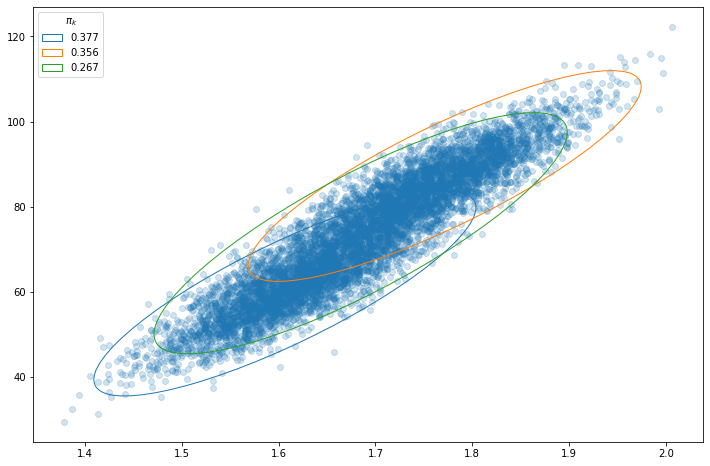

In [21]:
from mchlearn.plotting import confidence_ellipse
plt.scatter(hw_train['Height'], hw_train['Weight'], alpha=0.2);
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(3):
    confidence_ellipse(hw_gm3.means_[i], hw_gm3.covariances_[i], ax = plt.gca(), edgecolor=cycle[i], label =f"{hw_gm3.weights_[i]:5.3f}");
plt.legend(title='$\pi_k$');    

we see that there is not a clear interpretation to be given to different clusters and that their weights are similar. Let's see how good is the fit

In [22]:
print(f"2 clusters {-hw_gm.score(hw_test[['Height', 'Weight']]):6.4f}  3 clusters {-hw_gm3.score(hw_test[['Height', 'Weight']]):6.4f}")

2 clusters 2.1738  3 clusters 2.1740


We see that it is only marginally different then in case of two clusters. 

Actually we  should also not use the test set for choosing the number of components.  We should use a separate validation set. If we  do not have enough data we can recourse to cross valdation

In [23]:
from sklearn.model_selection import cross_validate
cv2 = cross_validate(hw_gm, hw_train[['Height', 'Weight']])
print(cv2)

{'fit_time': array([0.07936096, 0.08478522, 0.09465313, 0.09684515, 0.08547616]), 'score_time': array([0.00210571, 0.00210786, 0.00217867, 0.00263667, 0.00226498]), 'test_score': array([-2.19925577, -2.1523609 , -2.20503724, -2.21355948, -2.1648391 ])}


In [24]:
cv3 = cross_validate(hw_gm3, hw_train[['Height', 'Weight']])
print(cv3)

{'fit_time': array([0.40742779, 0.3998971 , 0.48710394, 0.42968774, 0.38481712]), 'score_time': array([0.00237608, 0.00244308, 0.00237226, 0.00245309, 0.00243378]), 'test_score': array([-2.19919368, -2.15297964, -2.20646461, -2.21382867, -2.16443234])}


In [25]:
print(f"2 clusters {-cv2['test_score'].mean():6.4f}  3 clusters {-cv3['test_score'].mean():6.4f}")

2 clusters 2.1870  3 clusters 2.1874


We see that the results are almost indistinguishable. But note that their are also different from the values obtained on the test set. That's because all of those are  statistical estimators so actually they are random variables themself :( The  estimate of variance of those estimators  is  difficult  and beyond the subject of this lecture. Interested readers may consult [No Unbiased Estimator of the Variance of K-Fold Cross-Validation](http://www.jmlr.org/papers/volume5/grandvalet04a/grandvalet04a.pdf).

### Akaike information criterion (AIC)

Cross validation, while popular is a time consuming technique as it requires fitting the model several times. There is a method to remove the bias from the likelihood estimator in form of the so called [Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AIC). It takes into acount the number of parameters that were used to fit the model and tries to compensate for it.

In [26]:
# we have to refit the clusters
hw_gm3.fit(hw_train[['Height', 'Weight']])

GaussianMixture(n_components=3, n_init=3, tol=1e-05)

In [27]:
#AIC is normalized differently from score method so we have to rescale it
0.5*hw_gm3.aic(hw_train[['Height', 'Weight']])/len(hw_train)

2.18741709379325

### Bayesian information criterion

Another similar measure is provided by [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (BIC) 

In [28]:
0.5*hw_gm3.bic(hw_train[['Height', 'Weight']])/len(hw_train)

2.1948409904152033

We will now do some more systematic analysis by checking fits in the range from one to five clusters. We start by generating the `GaussianMixture` objects with different number of components

In [29]:
gmms = [GaussianMixture(n_components=i, tol=1e-4, max_iter=500, n_init=3) for i in range(1,6)]

and run cross validation on them

In [30]:
cvs =  [cross_validate(gm, hw_train[['Height', 'Weight']], y=None, cv=5) for gm in gmms]

Finally we retrain them on the full  training dataset

In [31]:
for gm in gmms:
    gm.fit(hw_train[['Height', 'Weight']])

The picture belowe summarizes  different  performance measures. While  the pictures will differ in each evaluation of the notebook they all show a sharp decline at $N_c=2$ and then level-off,  indicating that two clusters is probably a good choice. 

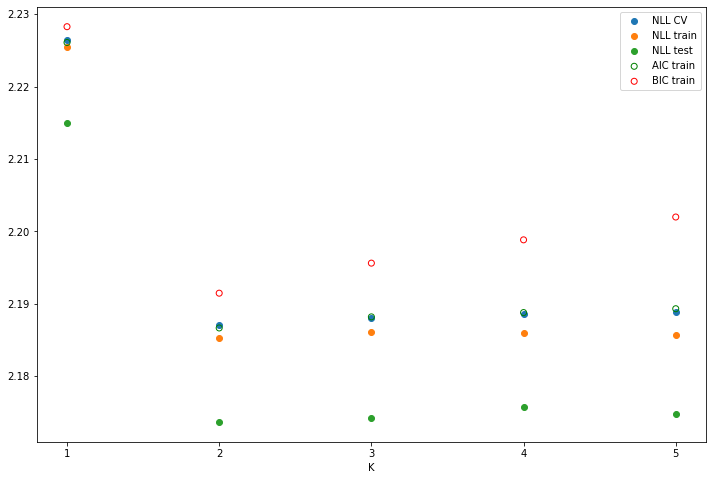

In [32]:
n_samples = len(hw_train)
plt.scatter(np.arange(1,6), [-c['test_score'].mean() for c in cvs], label='NLL CV');
plt.scatter(np.arange(1,6), [-gm.score(hw_train[['Height', 'Weight']]) for gm in gmms], label='NLL train');
plt.scatter(np.arange(1,6), [-gm.score(hw_test[['Height', 'Weight']]) for gm in gmms], label='NLL test');
plt.scatter(np.arange(1,6), [0.5*gm.aic(hw_train[['Height', 'Weight']])/n_samples for gm in gmms], label='AIC train', facecolor='none', edgecolors='green');
plt.scatter(np.arange(1,6), [0.5*gm.bic(hw_train[['Height', 'Weight']])/n_samples for gm in gmms], label='BIC train', facecolor='none', edgecolors='red');
plt.xticks(np.arange(1,6));
plt.xlabel("K");
plt.legend();

## More clusters

Unfortunatelly the situation is not always that clear. Let's look at combination of five clusters. I will use 1D example for easier visualisation.

In [33]:
#My helper class
import mchlearn.mixture as mix
#The arguments are means, stan dard deviations and relative weights of the clusters
fiver = mix.Gaussian1D([-2,-1,0,1,2],[0.3,1,0.3,0.4,.75],[1,2,3,2,1])

In [34]:
data5=fiver.rvs(5000)
x5 = data5[:,0]

The plot below shows all contributing clusters, resulting pdf and the data histogram

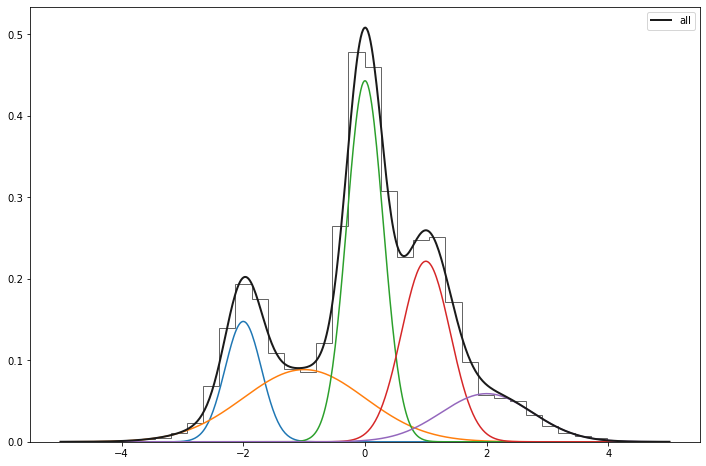

In [35]:
ps = np.linspace(-5,5,500)
plt.plot(ps,fiver.pdf(ps,sep=True));
plt.plot(ps,fiver.pdf(ps), color=(0.1, 0.1, 0.1), linewidth=2, label="all");
plt.hist(data5[:,0], bins=32, density=True, histtype='step', color=(.4,.4,.4), linewidth=1);
plt.legend();

We will perform the similar analysis as  previously but extend the range to 11 clusters.

In [36]:
test_data5  = fiver.rvs(1000)

In [37]:
f_gmms = [GaussianMixture(n_components=nc, tol=1e-4, max_iter=800, n_init=3) for nc in range(1, 12)]

In [38]:
f_cvs = [cross_validate(gm, x5.reshape(-1,1),y=None) for gm in f_gmms]

In [39]:
for gm in f_gmms:
    gm.fit(x5.reshape(-1,1))

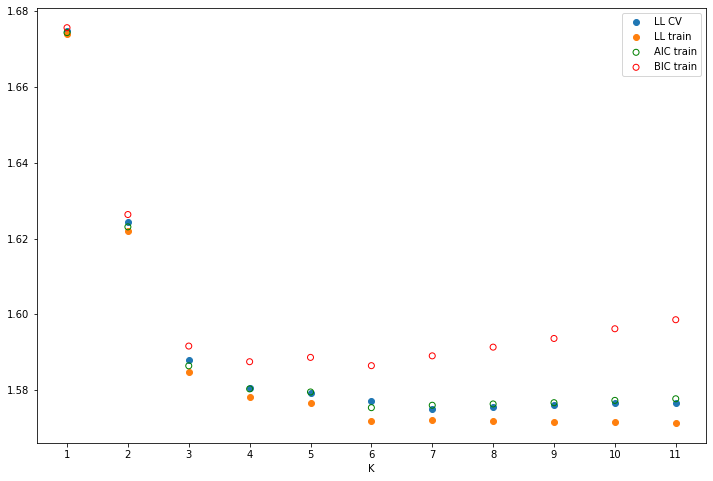

In [40]:
n_samples = len(x5)
plt.scatter(np.arange(1,12), [-c['test_score'].mean() for c in f_cvs], label='LL CV');
plt.scatter(np.arange(1,12), [-gm.score(x5.reshape(-1,1)) for gm in f_gmms], label='LL train');
plt.scatter(np.arange(1,12), [0.5*gm.aic(x5.reshape(-1,1))/n_samples for gm in f_gmms], label='AIC train', facecolor='none', edgecolors='green');
plt.scatter(np.arange(1,12), [0.5*gm.bic(x5.reshape(-1,1))/n_samples for gm in f_gmms], label='BIC train', facecolor='none', edgecolors='red');
plt.xticks(np.arange(1,12));
plt.xlabel("K");
plt.legend();

As you can see the results are less conclusive. 

Below I have plotted the means of the clusters discovered  for different number of clusters. The size of the dots is proportional to the cluster  weight. The label zero denotes the original, true mixture. 

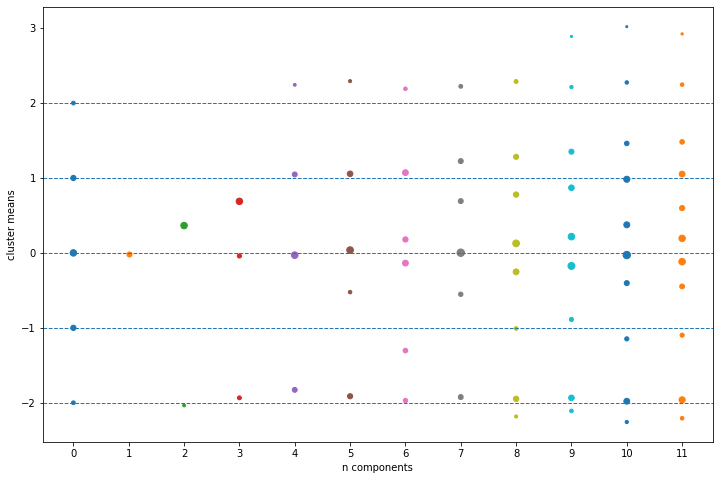

In [41]:
plt.scatter(np.zeros(5),fiver.dists_.mean(), s=5*25*fiver.pis_);
for m in fiver.dists_.mean():
    plt.axhline(m, linewidth=1, linestyle='--')
for gm in f_gmms:
    plt.scatter(gm.n_components*np.ones(gm.n_components),gm.means_, s=gm.n_components*25*gm.weights_);
plt.xticks(np.arange(0,12));
plt.xlabel('n components');
plt.ylabel('cluster means');

As you can see even for correct number of components the means are off (at least on my plot). Below I compare the resulting distributions. It seems that starting from five clusters there is very little difference. That illustrates my point that it is relatively easy to fit a good distribution but deciding on the interpretation of clusters is much harder. 

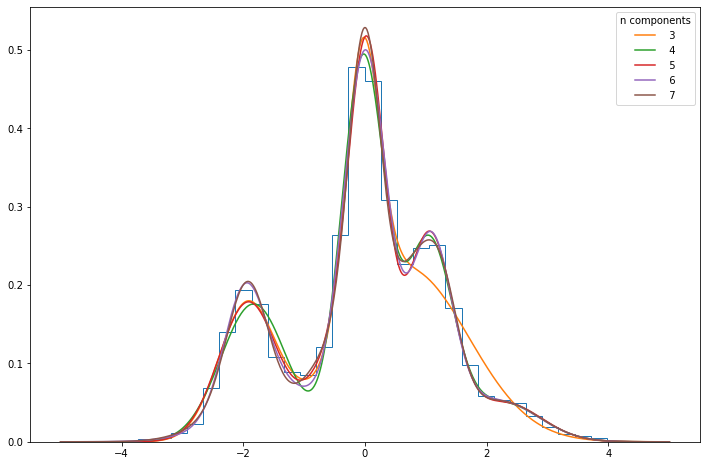

In [42]:
plt.hist(x5, bins=32, density=True, histtype='step');
ps = np.linspace(-5,5,500)
for nc in range(3,8):
    mixture = mix.Gaussian1D.FromGaussianMixture(f_gmms[nc-1])
    #plt.plot(ps,mixture.pdf(ps,sep=True));
    plt.plot(ps,mixture.pdf(ps), label='{:3d}'.format(nc));
plt.legend(title='n components');

### Using  GridSearchCV

Because we are using the  scikit-learn provided estimators for searching the optimal number of components we can use the "machinery" provided by this library for hyperparameters tuning e.g. the `GridSearchCV` class. I leave this as an excercise for the reader :) 

## Dirichlet process

An alternative to systematic search in the number of clusters is to perform a stochastic (i.e. random) search in the space of the possible models. In scikit-learn this is provided in a form of BayesianGaussianMixture class which implements sampling from the _Dirichlet process_.

This class has two important parameters: the maximal number of components and the weight concentration prior. The later controls the weight distribution (priors) of the cluster. Bigger values of this parameter favor the more uniform distribution of weights and hence more clusters being 'active'. The lower values will have tendency to set some weights to zero. 

In [43]:
from sklearn.mixture import BayesianGaussianMixture
n_comp = 11
wcps = [0.1, 0.25, 0.5,1,5,10,20,50]
bgms  = [BayesianGaussianMixture(n_components=n_comp,  
                               tol=1e-3, max_iter=2000, weight_concentration_prior=wcp) for wcp in wcps]

In [44]:
for bgm in bgms:
    bgm.fit(x5.reshape(-1,1))

Let's look how at the weight distribution

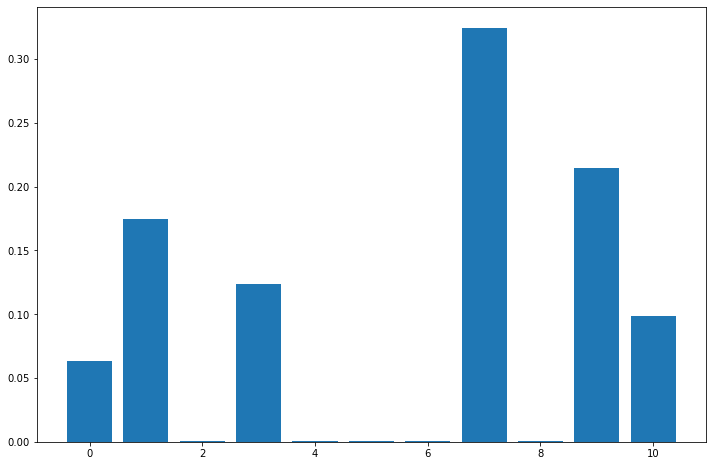

In [45]:
plt.bar(np.arange(n_comp),bgms[0].weights_);

As we can see only six out of eleven clusters have weight significantly greater then zero. 
Actually in this example this is true for most of the values of the weight concentration prior:

In [46]:
for bgm in bgms:
    print(f"{bgm.weight_concentration_prior_:6.2f}  {np.sum(bgm.weights_>0.001):2d}")

  0.10   6
  0.25   5
  0.50   6
  1.00   6
  5.00   5
 10.00   6
 20.00   6
 50.00   6


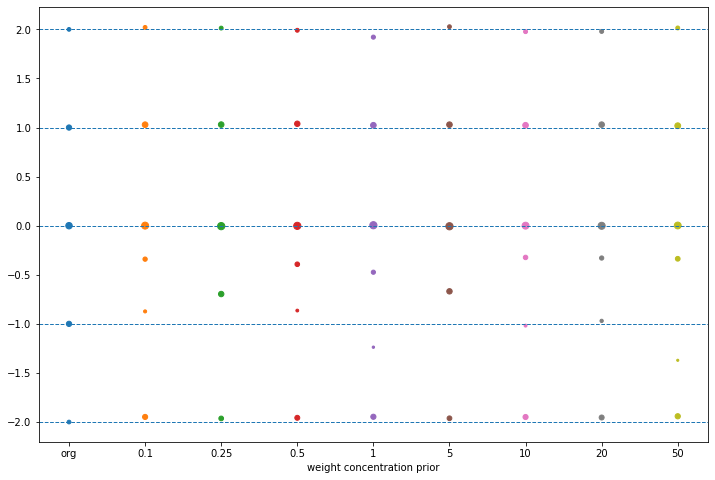

In [47]:
plt.scatter(np.zeros(5),fiver.dists_.mean(), s=5*25*fiver.pis_);
for m in fiver.dists_.mean():
    plt.axhline(m, linewidth=1, linestyle='--')
for i,bgm in enumerate(bgms):
    plt.scatter((i+1)*np.ones(bgm.n_components),bgm.means_.ravel(), s=6*25*bgm.weights_);
plt.xticks(np.arange(9),['org']+wcps)    ;
plt.xlabel('weight concentration prior');

In practice all the fits give very similar distributions

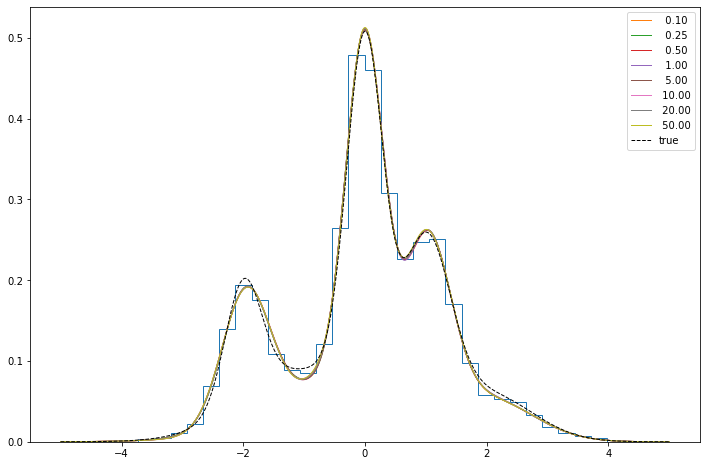

In [48]:
plt.hist(x5, bins=32, density=True, histtype='step');
ps = np.linspace(-5,5,500)
for bgm in bgms:
    mixture = mix.Gaussian1D.FromGaussianMixture(bgm)   
    plt.plot(ps,mixture.pdf(ps), linewidth=1, label=f"{bgm.weight_concentration_prior_:6.2f}");
plt.plot(ps,fiver.pdf(ps), label='true', color='black', linestyle='--', linewidth=1);
plt.legend();

altough the actual clusters slightly differ

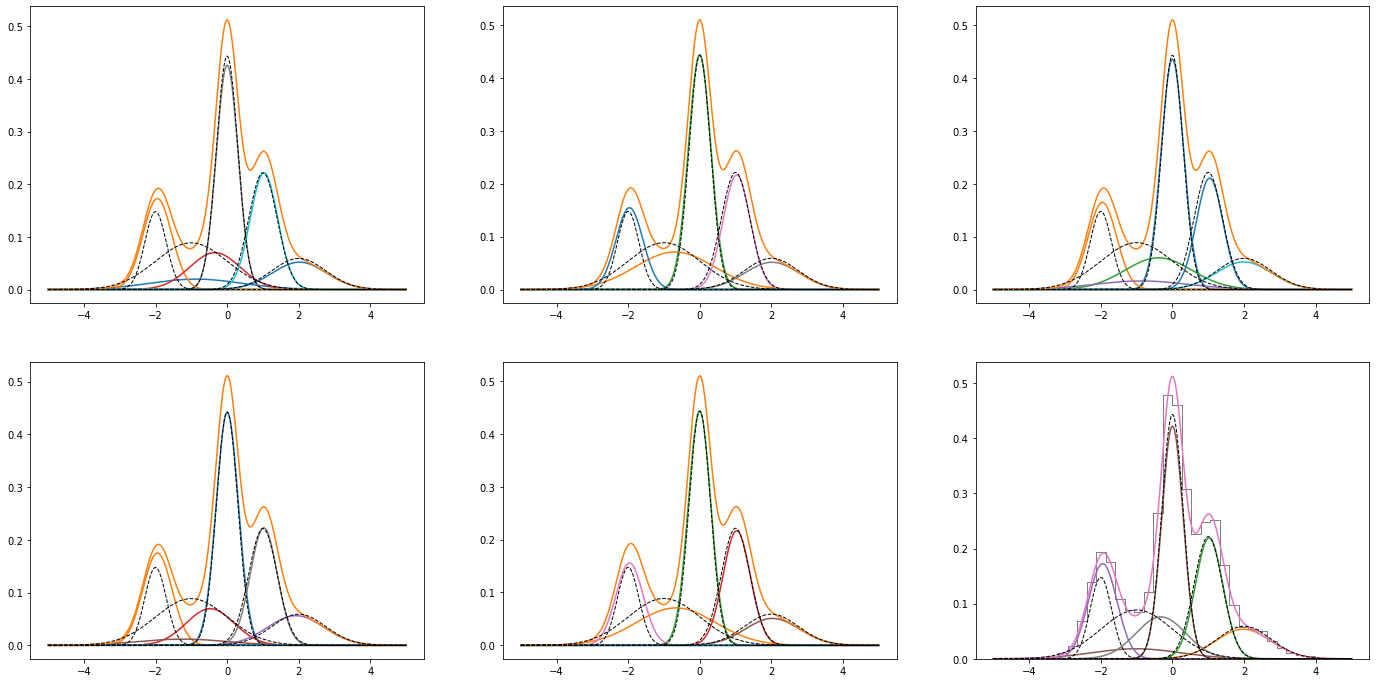

In [49]:
fig, ax = plt.subplots(2,3, figsize=(24,12),)
ps = np.linspace(-5,5,500)
ax = ax.ravel()
for i,bgm in enumerate(bgms[:6]):
    mixture = mix.Gaussian1D.FromGaussianMixture(bgm)   
    ax[i].plot(ps,mixture.pdf(ps, sep=True));
    ax[i].plot(ps,mixture.pdf(ps));
    ax[i].plot(ps,fiver.pdf(ps,sep=True), label='true', color='black', linestyle='--', linewidth=1);
    plt.hist(x5, bins=32, density=True, histtype='step');